# Predict next stock price based on market sentiment

In [9]:
import numpy as np
import scipy as sci
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import math
from stock2 import getAndProcessFinancialDataJSON, getStockTickers
from stock3 import getAndProcessMultiFinancialDataJSON, getAndProcessMultiFinancialDataJSONSentiment
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Dense, Dropout, LSTM

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# Data Preprocessing

In [10]:
# Get stock data from the internet

# Get 20 random tickers from NYSE
tickers = getStockTickers(20)
tickers = ["PBF", "TSLA", "ZM", "FLO", "SQ", "GPS", "VTRS", "LNC", "NRG", "ETSY"]
sentiment = [1, -1, -1, 1, -1, 1, 1, 1,-1, -1]

#tickers = ["AMD"]
# get stock data from those tickers
X_raw,y_raw = getAndProcessMultiFinancialDataJSONSentiment(tickers,sentiment, look_fwd=1, interval="5m", rge="1mo", simple=False)

#X_raw,y_raw = getAndProcessFinancialDataJSON("AMD",look_fwd=2)
print(tickers)
print("Data size: ",len(X_raw))

Loading data using URL [ https://query1.finance.yahoo.com/v8/finance/chart/PBF?interval=2m&range=1mo ]
Loading data using URL [ https://query1.finance.yahoo.com/v8/finance/chart/TSLA?interval=2m&range=1mo ]
Loading data using URL [ https://query1.finance.yahoo.com/v8/finance/chart/ZM?interval=2m&range=1mo ]
Loading data using URL [ https://query1.finance.yahoo.com/v8/finance/chart/FLO?interval=2m&range=1mo ]
Loading data using URL [ https://query1.finance.yahoo.com/v8/finance/chart/SQ?interval=2m&range=1mo ]
Loading data using URL [ https://query1.finance.yahoo.com/v8/finance/chart/GPS?interval=2m&range=1mo ]
Loading data using URL [ https://query1.finance.yahoo.com/v8/finance/chart/VTRS?interval=2m&range=1mo ]
Loading data using URL [ https://query1.finance.yahoo.com/v8/finance/chart/LNC?interval=2m&range=1mo ]
Loading data using URL [ https://query1.finance.yahoo.com/v8/finance/chart/NRG?interval=2m&range=1mo ]
Loading data using URL [ https://query1.finance.yahoo.com/v8/finance/char

In [11]:
unix_time = getAndProcessFinancialDataJSON(tickers[0],justTimes=True)
print(unix_time)

Loading data using URL [ https://query1.finance.yahoo.com/v8/finance/chart/PBF?interval=2m&range=1d ]
[1620912600, 1620912720, 1620912840, 1620912960, 1620913080, 1620913200, 1620913320, 1620913440, 1620913560, 1620913680, 1620913800, 1620913920, 1620914040, 1620914160, 1620914280, 1620914400, 1620914520, 1620914640, 1620914760, 1620914880, 1620915000, 1620915120, 1620915240, 1620915360, 1620915480, 1620915600, 1620915720, 1620915840, 1620915960, 1620916080, 1620916200, 1620916320, 1620916440, 1620916560, 1620916680, 1620916800, 1620916920, 1620917040, 1620917160, 1620917280, 1620917400, 1620917520, 1620917640, 1620917760, 1620917880, 1620918000, 1620918120, 1620918240, 1620918360, 1620918480, 1620918600, 1620918720, 1620918840, 1620918960, 1620919080, 1620919200, 1620919320, 1620919440, 1620919560, 1620919680, 1620919800, 1620919920, 1620920040, 1620920160, 1620920280, 1620920400, 1620920520, 1620920640, 1620920760, 1620920880, 1620921000, 1620921120, 1620921240, 1620921360, 162092148

In [12]:
X_raw_numpy = X_raw.to_numpy()
y_raw_numpy = y_raw.to_numpy()

In [13]:
# clean data
delete_list = []
for i in range(len(X_raw_numpy)):
    if(y_raw_numpy[i] == None):
        delete_list.append(i)
    for j in range(len(X_raw_numpy[0])):
        if(X_raw_numpy[i][j] == None):
            delete_list.append(i)
X_clean = np.delete(X_raw_numpy, delete_list, 0)
y_clean = np.delete(y_raw_numpy, delete_list, 0)
# np.isnan(y_raw[i])

print("original size:",len(y_raw))
print("elements to delete:",len(delete_list))
print("resulting size:",len(y_clean))
print("result+delete size:",len(y_clean) + len(delete_list))

original size: 42890
elements to delete: 214
resulting size: 42686
result+delete size: 42900


In [14]:
print(X_clean)
print(y_clean)
print(len(X_clean))
print(len(y_clean))

[[1.0 13.84000015258789]
 [1.0 13.859999656677246]
 [1.0 13.86400032043457]
 ...
 [-1.0 157.24000549316406]
 [-1.0 156.64999389648438]
 [-1.0 156.5500030517578]]
[[13.859999656677246]
 [13.86400032043457]
 [13.84000015258789]
 ...
 [156.64999389648438]
 [156.5500030517578]
 [156.6300048828125]]
42686
42686


In [15]:
# Split into train, validate, and test sets
size = len(X_clean)

# Get test size and data
total_train_size = (size*8)//10
test_size = size - total_train_size

X_total_train_unnorm = X_clean[:total_train_size]
y_total_train_unnorm = y_clean[:total_train_size]

X_test_unnorm = X_clean[total_train_size:]
y_test_unnorm = y_clean[total_train_size:]

# Get train and validation size and data
train_size = (total_train_size*8)//10
val_size = total_train_size - train_size

X_train_unnorm = X_total_train_unnorm[:train_size]
y_train_unnorm = y_total_train_unnorm[:train_size]

X_val_unnorm = X_total_train_unnorm[train_size:]
y_val_unnorm = y_total_train_unnorm[train_size:]



In [16]:
print(total_train_size)
print(train_size)
print(val_size)
print(test_size)
print()
print(len(X_total_train_unnorm))
print(len(X_train_unnorm))
print(len(X_val_unnorm))
print(len(X_test_unnorm))
print()
print(len(y_total_train_unnorm))
print(len(y_train_unnorm))
print(len(y_val_unnorm))
print(len(y_test_unnorm))

34148
27318
6830
8538

34148
27318
6830
8538

34148
27318
6830
8538


In [17]:
# Scale between 0 and 1, best for LSTM models
scaler = MinMaxScaler(feature_range=(0, 1))
X_train_norm = scaler.fit_transform(X_train_unnorm)
y_train_norm = scaler.fit_transform(y_train_unnorm)

X_val_norm = scaler.fit_transform(X_val_unnorm)
y_val_norm = scaler.fit_transform(y_val_unnorm)

X_test_norm = scaler.fit_transform(X_test_unnorm)
y_test_norm = scaler.fit_transform(y_test_unnorm)

In [18]:
# Let's try transposing y...
y = y_train_norm.transpose()[0]
y_val = y_val_norm.transpose()[0]
y_test = y_test_norm.transpose()[0]

In [19]:
# LSTM also needs to adhere to this shape
X =      np.reshape(X_train_norm, (     X_train_norm.shape[0],  1, X_train_norm.shape[1]))
X_val =  np.reshape(X_val_norm,   (     X_val_norm.shape[0],    1, X_val_norm.shape[1]))
X_test = np.reshape(X_test_norm,  (     X_test_norm.shape[0],   1, X_test_norm.shape[1]))
# y =      np.reshape(y_train_norm, (     y_train_norm.shape[0],  -1, y_train_norm.shape[1]))  # y_train_norm  
# y_val =  np.reshape(y_val_norm,   (     y_val_norm.shape[0],    -1, y_val_norm.shape[1]))    # y_val_norm
# y_test = np.reshape(y_test_norm,  (     y_test_norm.shape[0],   -1, y_test_norm.shape[1]))   # y_test_norm  

In [20]:
# Prints for sanity
print(X[0])
print(y)


print(len(X))
print(len(y))

[[1.         0.00234209]]
[0.00236811 0.00237332 0.00234209 ... 0.00179911 0.00179235 0.00178038]
27318
27318


# Model Creation 

In [122]:
# create the LSTM model
input_shape = (1,  2)
print(input_shape)
model = Sequential()

model.add(LSTM(512, input_shape=input_shape, return_sequences=True)) #, return_sequences=True))
model.add(LSTM(256)) #, return_sequences=True))

# Shape = [# of elements, data per element (1)]
model.add(Dense(128, activation='tanh',kernel_regularizer=tf.keras.regularizers.L1(0.01),activity_regularizer=tf.keras.regularizers.L2(0.01)))
model.add(Dense(64, activation='tanh',kernel_regularizer=tf.keras.regularizers.L1(0.01),activity_regularizer=tf.keras.regularizers.L2(0.01)))
model.add(Dense(32, activation='tanh',kernel_regularizer=tf.keras.regularizers.L1(0.01),activity_regularizer=tf.keras.regularizers.L2(0.01)))
model.add(Dense(8, activation='tanh',kernel_regularizer=tf.keras.regularizers.L1(0.01),activity_regularizer=tf.keras.regularizers.L2(0.01)))
model.add(Dense(1))
# learning_rate=0.001
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=["accuracy","mse"])

model.summary()

# mean square error r2 regularization - use regressions

(1, 2)
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, 1, 512)            1054720   
_________________________________________________________________
lstm_11 (LSTM)               (None, 256)               787456    
_________________________________________________________________
dense_13 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_14 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_15 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_16 (Dense)             (None, 8)                 264       
_________________________________________________________________
dense_17 (Dense)             (None, 1)         

# Training

In [125]:
# Train
history = model.fit(X, y, epochs=20, batch_size=4, verbose=1, validation_data=(X_val, y_val))
print("Done!")

Epoch 1/20
6830/6830 [==============================] - 33s 5ms/step - loss: 0.4162 - accuracy: 7.3212e-05 - mse: 0.0022 - val_loss: 0.7779 - val_accuracy: 2.9283e-04 - val_mse: 0.0013
Epoch 2/20
6830/6830 [==============================] - 34s 5ms/step - loss: 0.4635 - accuracy: 7.3212e-05 - mse: 0.0035 - val_loss: 0.3432 - val_accuracy: 2.9283e-04 - val_mse: 8.2467e-04
Epoch 3/20
6830/6830 [==============================] - 32s 5ms/step - loss: 0.4655 - accuracy: 3.6606e-05 - mse: 0.0055 - val_loss: 0.3470 - val_accuracy: 2.9283e-04 - val_mse: 8.2210e-04
Epoch 4/20
6830/6830 [==============================] - 30s 4ms/step - loss: 0.4150 - accuracy: 7.3212e-05 - mse: 0.0027 - val_loss: 0.3370 - val_accuracy: 2.9283e-04 - val_mse: 0.0016
Epoch 5/20
6830/6830 [==============================] - 34s 5ms/step - loss: 0.4059 - accuracy: 7.3212e-05 - mse: 0.0017 - val_loss: 0.3271 - val_accuracy: 2.9283e-04 - val_mse: 0.0016
Epoch 6/20
6830/6830 [==============================] - 34s 5ms/ste

# Model Training Results

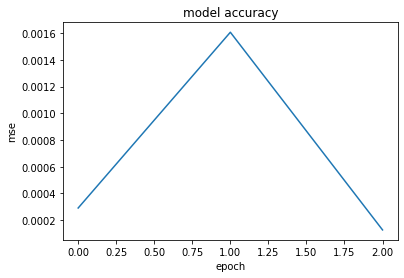

In [110]:
# plot loss and accuracy
plt.plot(history.history['mse'])
plt.title('model accuracy')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.show()


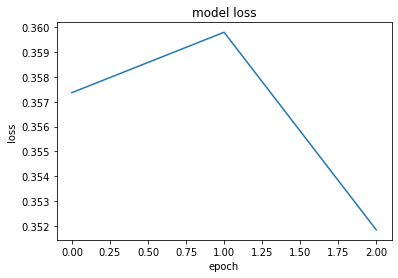

In [111]:
# plot loss and accuracy
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

In [112]:
predictions = model(X_test)


In [113]:
model_guess = scaler.inverse_transform(predictions)
real_answer = scaler.inverse_transform([y_test])

In [114]:
testScore = math.sqrt(mean_squared_error(real_answer[0], model_guess[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Test Score: 12.04 RMSE


# Next minute test

In [115]:
X_raw_2,y_raw_2 = getAndProcessMultiFinancialDataJSONSentiment(["GOOG"],[1],look_fwd=1, interval="2m", rge="1mo",simple=False)
X_raw_numpy_2 = X_raw_2.to_numpy() # np.array([[1,i] for i in range(1000)])
y_raw_numpy_2 = y_raw_2.to_numpy() # np.array([[-i,] for i in range(1000)])

# clean data
delete_list = []
for i in range(len(X_raw_numpy_2)):
    if(y_raw_numpy_2[i] == None):
        delete_list.append(i)
    for j in range(len(X_raw_numpy_2[0])):
        if(X_raw_numpy_2[i][j] == None):
            delete_list.append(i)
X_clean_2 = np.delete(X_raw_numpy_2, delete_list, 0)
actual_google_price = np.delete(y_raw_numpy_2, delete_list, 0)
actual_google_price = actual_google_price.astype(np.float)
scaler_2 = MinMaxScaler(feature_range=(0, 1))
X_train_norm_2 = scaler_2.fit_transform(X_clean_2)
not_needed = scaler_2.fit_transform(actual_google_price)

X_2 =      np.reshape(X_train_norm_2, (     X_train_norm_2.shape[0],  1, X_train_norm_2.shape[1]))


Loading data using URL [ https://query1.finance.yahoo.com/v8/finance/chart/GOOG?interval=2m&range=1mo ]


In [116]:
print(X_2[0])

[[0.         0.18530715]]


In [117]:
predicted_price = model(X_2)

In [118]:
predicted_google_price = scaler_2.inverse_transform(predicted_price)

Text(0.5, 0, 'Time (delta = 2 minutes)')

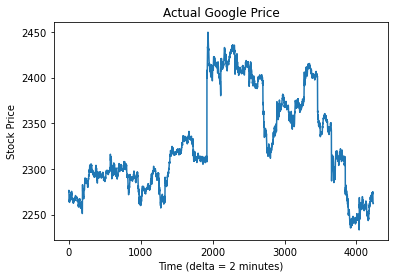

In [119]:
plt.plot(actual_google_price)
plt.title("Actual Google Price")
plt.ylabel("Stock Price")
plt.xlabel("Time (delta = 2 minutes)")

Text(0.5, 0, 'Time (delta = 2 minutes)')

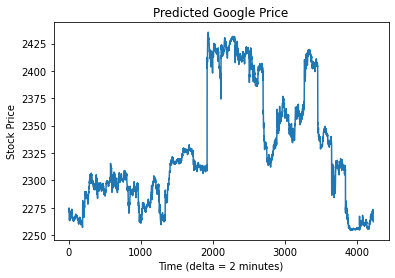

In [120]:
plt.plot(predicted_google_price)
plt.title("Predicted Google Price")
plt.ylabel("Stock Price")
plt.xlabel("Time (delta = 2 minutes)")

# Stock Predictor Test 1 (Into the future with one sample)

step 29
Mean square error: 21.40747674229367


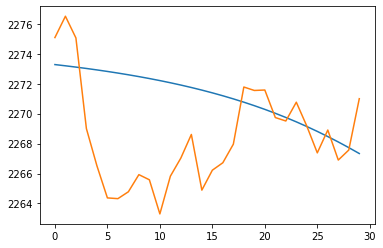

In [149]:
# Get sentiment
senti = X_2[0][0][0]

# number of 2 minute steps into the future you want to predict into
steps = 30

# Set initial input
prev_price = np.array([X_2[0]])

# loop 

prices = []

for i in range(steps):
    print(f"step {i}",end='\r')
    unscaled = scaler_2.inverse_transform(prev_price[0])
    prices.append(unscaled[0][1])
    # Predict
    next_price = model(prev_price)

    # Extract prediction
    next_point_val = next_price.numpy()[0][0]

    # generate a new numpy array with prediction and general sentiment
    simple_array = np.array([senti, next_point_val])

    prev_price = np.reshape(simple_array,(1,1,2))
print()
plt.plot(prices)
plt.plot(actual_google_price[:steps])

# calculate error

predictions = np.array(actual_google_price[:steps].transpose()[0])
actual = np.array(prices)
mse = (np.square(predictions - actual)).mean(axis=None)
print("Mean square error:",mse)


# Stock Predictor Test 2 (Figuring out points within region)

In [244]:
def transform_foward(array_2d):

    scaler_2 = MinMaxScaler(feature_range=(0, 1))
    result = np.array(array_2d)
    result_cols = scaler_2.fit_transform(array_2d.transpose()[1].reshape(-1, 1))
    result[:,1] = result_cols.reshape(-1,)

    return (result,scaler_2)


# does not get you your sentiment back
def transform_back(result_2d, scaler):

    result = np.array(result_2d)
    result_cols = scaler.inverse_transform(result_2d.transpose()[1].reshape(-1, 1))
    return result_cols.transpose()[0]

# input a 2d [[senti, result]] array
def transform_back_single(result_nested_arrays, scaler):
    result_cols = scaler.inverse_transform(result_nested_arrays[0].reshape(-1, 1))
    return result_cols.transpose()[0][1]



In [235]:
X_raw_2,y_raw_2 = getAndProcessMultiFinancialDataJSONSentiment(["GOOG"],[1],look_fwd=1, interval="1m", rge="1mo",simple=False)
X_raw_numpy_2 = X_raw_2.to_numpy() # np.array([[1,i] for i in range(1000)])
y_raw_numpy_2 = y_raw_2.to_numpy() # np.array([[-i,] for i in range(1000)])

# clean data
delete_list = []
for i in range(len(X_raw_numpy_2)):
    if(y_raw_numpy_2[i] == None):
        delete_list.append(i)
    for j in range(len(X_raw_numpy_2[0])):
        if(X_raw_numpy_2[i][j] == None):
            delete_list.append(i)
X_clean_2 = np.delete(X_raw_numpy_2, delete_list, 0)
actual_google_price = np.delete(y_raw_numpy_2, delete_list, 0)
actual_google_price = actual_google_price.astype(np.float)

X_train_norm_2, scaler_2_back = transform_foward(X_clean_2)

not_needed = scaler_2.fit_transform(actual_google_price)
X_2 =      np.reshape(X_train_norm_2, (     X_train_norm_2.shape[0],  1, X_train_norm_2.shape[1]))

Loading data using URL [ https://query1.finance.yahoo.com/v8/finance/chart/GOOG?interval=2m&range=1mo ]


In [236]:
print(X_2)

[[[1.0 0.1439331251479654]]

 [[1.0 0.14605706684103126]]

 [[1.0 0.15134437392196354]]

 ...

 [[1.0 0.33879801134121657]]

 [[1.0 0.28888087212382807]]

 [[1.0 0.2948378296111738]]]


Sentiment 1.0
step 0
[[[1.0 0.1439331251479654]]]
step 1
[[[1.0 0.1439331251479654]]]
step 2
[[[0.5        0.37236732]]]
step 3
[[[0.5        0.44663611]]]
step 4
[[[0.5        0.45860413]]]
step 5
[[[1.0 0.15085961015974725]]]
step 6
[[[1.0 0.15085961015974725]]]
step 7
[[[0.5        0.38620946]]]
step 8
[[[0.5        0.44862294]]]
step 9
[[[0.5        0.45902541]]]
step 10
[[[1.0 0.15501505022378126]]]
step 11
[[[1.0 0.15501505022378126]]]
step 12
[[[0.5        0.39334783]]]
step 13
[[[0.5        0.44964588]]]
step 14
[[[0.5       0.4592461]]]
step 15
[[[1.0 0.16896046356943906]]]
step 16
[[[1.0 0.16896046356943906]]]
step 17
[[[0.5        0.41195452]]]
step 18
[[[0.5        0.45241293]]]
step 19
[[[0.5        0.45985574]]]
step 20
[[[1.0 0.16510490062342953]]]
step 21
[[[1.0 0.16510490062342953]]]
step 22
[[[0.5        0.40754089]]]
step 23
[[[0.5        0.45173603]]]
step 24
[[[0.5        0.45970479]]]
step 25
[[[1.0 0.1805970485778392]]]
step 26
[[[1.0 0.1805970485778392]]]
step 2

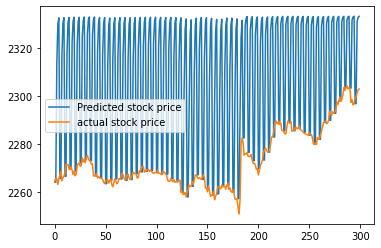

In [249]:
# Get sentiment
senti = X_2[0][0][0]
print("Sentiment", senti)
senti = 0.5

# number of 2 minute steps into the future you want to predict into
steps = 300

# Will predict correcting itself every 3*interval seconds/minutes/hours/etc.
interpolation_numb = 5

# Set initial input
prev_price = np.array([X_2[0]])
# loop 

prices = []

for i in range(steps):
    print(f"step {i}")
    # print(prev_price)
    prev_price.astype('float32')
    if (i % interpolation_numb == 0):
        prev_price = np.array([X_2[i]])
        print(prev_price)
        unscaled = transform_back_single(prev_price[0], scaler_2_back)
        prices.append(unscaled)
    else:
        # use previous to predict next
        unscaled = transform_back_single(prev_price[0], scaler_2_back)
        prices.append(unscaled)

        # Predict
        print(prev_price)

        next_price = model(prev_price.astype('float32'))

        # Extract prediction
        next_point_val = next_price.numpy()[0][0]

        # generate a new numpy array with prediction and general sentiment
        simple_array = np.array([senti, next_point_val])

        prev_price = np.reshape(simple_array,(1,1,2))
print()
plt.plot(prices)
plt.plot(actual_google_price[:steps])
plt.legend(['Predicted stock price', 'actual stock price'])

# calculate error

predictions = np.array(actual_google_price[:steps].transpose()[0])
actual = np.array(prices)
mse = (np.square(predictions - actual)).mean(axis=None)
print("Mean square error:",mse)

- They way this is set up you would rather want longer range stock predictions than shorter range
- Beacuse as you keep going along before the next correct point, the accuracy drops 